In [1]:
import torch
from torch import nn, Tensor
from ebm.buffer import Buffer
from ebm.langevin_sampler import LangevinSampler
from ebm.trainer import EnergyModelTrainer
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from typing import Tuple, Union, Callable
import copy
from matplotlib import pyplot as plt

import sys
import os

from models.mlp import MLP

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

In [4]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=transform,
)

In [5]:
# Filter for single class (T-shirts/tops) for simpler learning
target_label = 0
training_data_incides = torch.where(training_data.targets == target_label)[0]
test_data_incides = torch.where(test_data.targets == target_label)[0]

training_data = Subset(training_data, training_data_incides)
test_data = Subset(test_data, test_data_incides)

In [6]:
# Train/validation split
val_fraction = 0.1
dataset_size = len(training_data)
val_size = int(val_fraction * dataset_size)
train_size = dataset_size - val_size

# Create a reproducible shuffled list of indices
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(dataset_size, generator=generator).tolist()

# Split indices for train and validation
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap Subsets for train and validation datasets
train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

In [7]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(f"Training batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
Training batches: 47
Test batches: 8


In [8]:
model = MLP([784, 512, 512, 1], device = device, flat=True)
buffer = Buffer(256, [1, 28, 28], 0.05, device)
sampler = LangevinSampler(model, 60, 10, 5e-3, buffer)

In [11]:
model_save_path = '../models/ebm.pth'
trainer = EnergyModelTrainer(model, 1e-1, 5e-3, sampler, device, 1e-4, 10, model_save_path)

100%|██████████| 5/5 [00:00<00:00, 22.95it/s]


Epoch 1 completed. Train: Loss: 0.10525, CD Loss: -0.03668, Reg Loss: 0.14193, E_real: -0.8224, E_fake: -0.7857,
Val: Loss: -0.05467, CD Loss: -0.18510, Reg Loss: 0.13043, E_real: -0.8908, E_fake: -0.7057, E_rand: 0.5599, # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 23.23it/s]


Epoch 2 completed. Train: Loss: -0.10067, CD Loss: -0.19559, Reg Loss: 0.09492, E_real: -0.7724, E_fake: -0.5768,
Val: Loss: -0.06871, CD Loss: -0.18190, Reg Loss: 0.11319, E_real: -0.8336, E_fake: -0.6517, E_rand: 0.5834, # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 19.85it/s]


Epoch 3 completed. Train: Loss: -0.10517, CD Loss: -0.19191, Reg Loss: 0.08674, E_real: -0.7384, E_fake: -0.5465,
Val: Loss: -0.12997, CD Loss: -0.18439, Reg Loss: 0.05442, E_real: -0.5992, E_fake: -0.4149, E_rand: 0.6406, # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 24.76it/s]


Epoch 4 completed. Train: Loss: -0.10975, CD Loss: -0.18766, Reg Loss: 0.07792, E_real: -0.7005, E_fake: -0.5129,
Val: Loss: -0.05173, CD Loss: -0.12032, Reg Loss: 0.06859, E_real: -0.6336, E_fake: -0.5132, E_rand: 0.7291, (Best: -0.12997 at epoch 3)


100%|██████████| 5/5 [00:00<00:00, 21.21it/s]


Epoch 5 completed. Train: Loss: -0.11151, CD Loss: -0.18403, Reg Loss: 0.07253, E_real: -0.6743, E_fake: -0.4902,
Val: Loss: -0.10558, CD Loss: -0.16648, Reg Loss: 0.06090, E_real: -0.6199, E_fake: -0.4534, E_rand: 0.8294, (Best: -0.12997 at epoch 3)


100%|██████████| 5/5 [00:00<00:00, 22.21it/s]


Epoch 6 completed. Train: Loss: -0.11279, CD Loss: -0.17647, Reg Loss: 0.06368, E_real: -0.6318, E_fake: -0.4553,
Val: Loss: -0.04474, CD Loss: -0.12511, Reg Loss: 0.08037, E_real: -0.6866, E_fake: -0.5615, E_rand: 0.8956, (Best: -0.12997 at epoch 3)


100%|██████████| 5/5 [00:00<00:00, 18.47it/s]


Epoch 7 completed. Train: Loss: -0.11481, CD Loss: -0.17458, Reg Loss: 0.05976, E_real: -0.6111, E_fake: -0.4365,
Val: Loss: -0.08881, CD Loss: -0.15806, Reg Loss: 0.06926, E_real: -0.6564, E_fake: -0.4984, E_rand: 1.0032, (Best: -0.12997 at epoch 3)


100%|██████████| 5/5 [00:00<00:00, 23.93it/s]


Epoch 8 completed. Train: Loss: -0.12279, CD Loss: -0.18138, Reg Loss: 0.05858, E_real: -0.6008, E_fake: -0.4194,
Val: Loss: -0.10380, CD Loss: -0.13653, Reg Loss: 0.03273, E_real: -0.4542, E_fake: -0.3177, E_rand: 1.0800, (Best: -0.12997 at epoch 3)


100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Epoch 9 completed. Train: Loss: -0.12074, CD Loss: -0.17310, Reg Loss: 0.05236, E_real: -0.5619, E_fake: -0.3887,
Val: Loss: -0.10494, CD Loss: -0.15764, Reg Loss: 0.05269, E_real: -0.5768, E_fake: -0.4192, E_rand: 1.2385, (Best: -0.12997 at epoch 3)


100%|██████████| 5/5 [00:00<00:00, 22.77it/s]


Epoch 10 completed. Train: Loss: -0.12619, CD Loss: -0.17390, Reg Loss: 0.04771, E_real: -0.5295, E_fake: -0.3556,
Val: Loss: -0.07606, CD Loss: -0.15766, Reg Loss: 0.08160, E_real: -0.7068, E_fake: -0.5491, E_rand: 1.3919, (Best: -0.12997 at epoch 3)


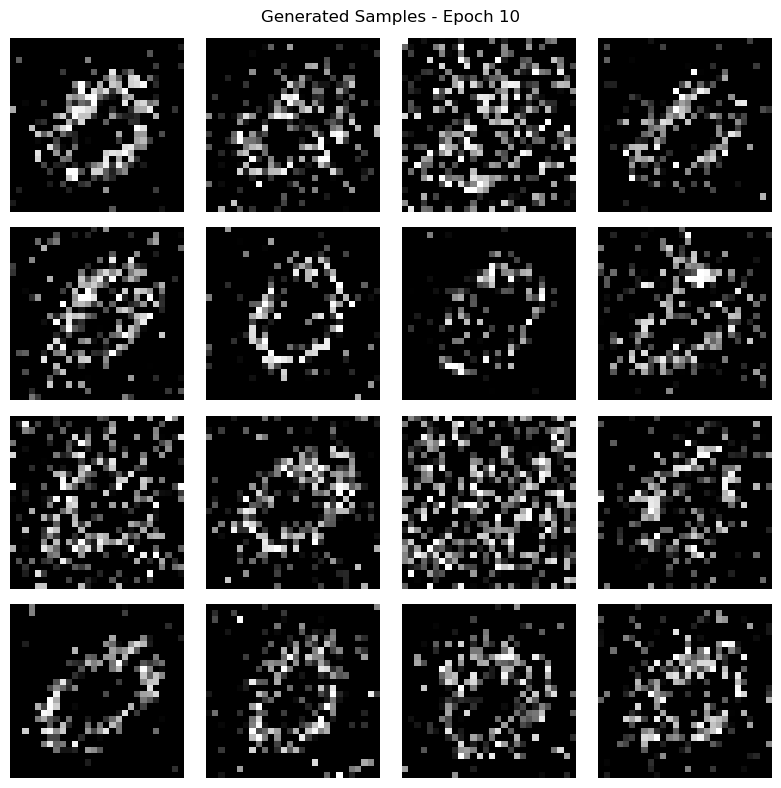

100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


Epoch 11 completed. Train: Loss: -0.12658, CD Loss: -0.17352, Reg Loss: 0.04695, E_real: -0.5166, E_fake: -0.3431,
Val: Loss: -0.12190, CD Loss: -0.14734, Reg Loss: 0.02545, E_real: -0.3995, E_fake: -0.2522, E_rand: 1.4766, (Best: -0.12997 at epoch 3)


100%|██████████| 5/5 [00:00<00:00, 21.52it/s]


Epoch 12 completed. Train: Loss: -0.12888, CD Loss: -0.17096, Reg Loss: 0.04208, E_real: -0.4834, E_fake: -0.3124,
Val: Loss: -0.05359, CD Loss: -0.11775, Reg Loss: 0.06416, E_real: -0.6132, E_fake: -0.4954, E_rand: 1.6388, (Best: -0.12997 at epoch 3)


100%|██████████| 5/5 [00:00<00:00, 21.19it/s]


Epoch 13 completed. Train: Loss: -0.13517, CD Loss: -0.17805, Reg Loss: 0.04288, E_real: -0.4758, E_fake: -0.2978,
Val: Loss: -0.16538, CD Loss: -0.17774, Reg Loss: 0.01236, E_real: -0.2688, E_fake: -0.0911, E_rand: 1.7481, # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 22.80it/s]


Epoch 14 completed. Train: Loss: -0.13579, CD Loss: -0.17352, Reg Loss: 0.03774, E_real: -0.4391, E_fake: -0.2655,
Val: Loss: -0.02509, CD Loss: -0.09052, Reg Loss: 0.06543, E_real: -0.6078, E_fake: -0.5172, E_rand: 1.9292, (Best: -0.16538 at epoch 13)


100%|██████████| 5/5 [00:00<00:00, 22.60it/s]


Epoch 15 completed. Train: Loss: -0.12857, CD Loss: -0.16607, Reg Loss: 0.03750, E_real: -0.4317, E_fake: -0.2656,
Val: Loss: -0.00650, CD Loss: -0.07763, Reg Loss: 0.07113, E_real: -0.6265, E_fake: -0.5488, E_rand: 2.0462, (Best: -0.16538 at epoch 13)


100%|██████████| 5/5 [00:00<00:00, 23.81it/s]


Epoch 16 completed. Train: Loss: -0.13294, CD Loss: -0.17051, Reg Loss: 0.03757, E_real: -0.4210, E_fake: -0.2505,
Val: Loss: -0.03936, CD Loss: -0.10851, Reg Loss: 0.06916, E_real: -0.6341, E_fake: -0.5256, E_rand: 2.2321, (Best: -0.16538 at epoch 13)


100%|██████████| 5/5 [00:00<00:00, 24.17it/s]


Epoch 17 completed. Train: Loss: -0.13317, CD Loss: -0.16844, Reg Loss: 0.03527, E_real: -0.3941, E_fake: -0.2256,
Val: Loss: -0.15847, CD Loss: -0.16670, Reg Loss: 0.00823, E_real: -0.1831, E_fake: -0.0164, E_rand: 2.2798, (Best: -0.16538 at epoch 13)


100%|██████████| 5/5 [00:00<00:00, 25.27it/s]


Epoch 18 completed. Train: Loss: -0.13106, CD Loss: -0.16280, Reg Loss: 0.03174, E_real: -0.3677, E_fake: -0.2049,
Val: Loss: -0.08523, CD Loss: -0.13781, Reg Loss: 0.05257, E_real: -0.5738, E_fake: -0.4360, E_rand: 2.4812, (Best: -0.16538 at epoch 13)


100%|██████████| 5/5 [00:00<00:00, 24.48it/s]


Epoch 19 completed. Train: Loss: -0.12821, CD Loss: -0.15988, Reg Loss: 0.03167, E_real: -0.3601, E_fake: -0.2003,
Val: Loss: -0.18400, CD Loss: -0.19107, Reg Loss: 0.00708, E_real: -0.1420, E_fake: 0.0490, E_rand: 2.4828, # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 24.56it/s]


Epoch 20 completed. Train: Loss: -0.13832, CD Loss: -0.16677, Reg Loss: 0.02845, E_real: -0.3169, E_fake: -0.1501,
Val: Loss: -0.04762, CD Loss: -0.09562, Reg Loss: 0.04800, E_real: -0.5207, E_fake: -0.4251, E_rand: 2.7124, (Best: -0.18400 at epoch 19)


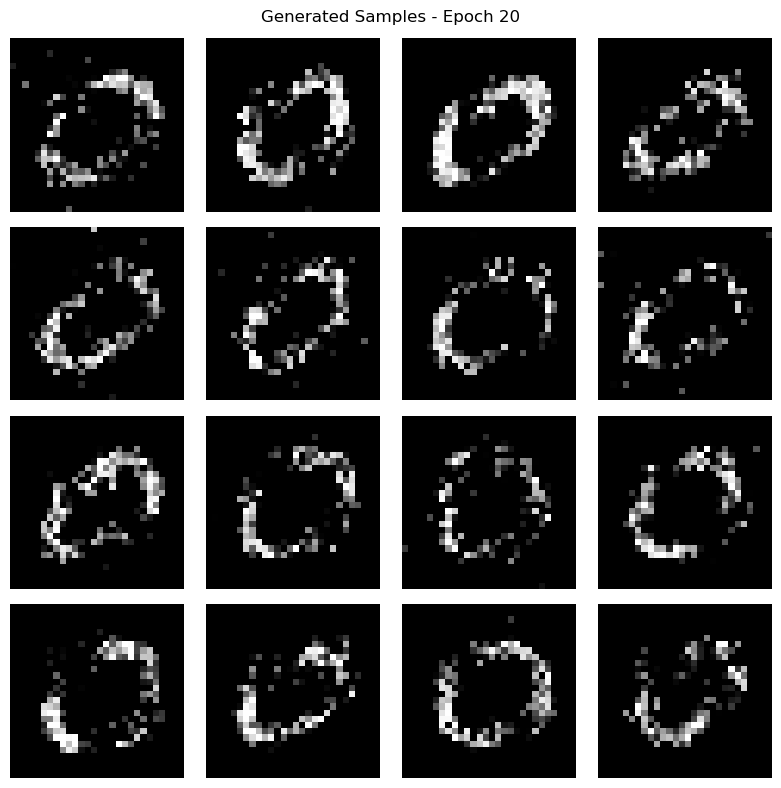

100%|██████████| 5/5 [00:00<00:00, 24.42it/s]


Epoch 21 completed. Train: Loss: -0.12589, CD Loss: -0.15358, Reg Loss: 0.02770, E_real: -0.3255, E_fake: -0.1719,
Val: Loss: -0.17654, CD Loss: -0.18407, Reg Loss: 0.00753, E_real: -0.0758, E_fake: 0.1083, E_rand: 2.7032, (Best: -0.18400 at epoch 19)


100%|██████████| 5/5 [00:00<00:00, 22.28it/s]


Epoch 22 completed. Train: Loss: -0.12903, CD Loss: -0.15736, Reg Loss: 0.02833, E_real: -0.3158, E_fake: -0.1584,
Val: Loss: -0.04563, CD Loss: -0.08587, Reg Loss: 0.04023, E_real: -0.4818, E_fake: -0.3959, E_rand: 2.9302, (Best: -0.18400 at epoch 19)


100%|██████████| 5/5 [00:00<00:00, 25.33it/s]


Epoch 23 completed. Train: Loss: -0.12036, CD Loss: -0.14686, Reg Loss: 0.02650, E_real: -0.3172, E_fake: -0.1703,
Val: Loss: -0.18550, CD Loss: -0.19743, Reg Loss: 0.01192, E_real: -0.0678, E_fake: 0.1296, E_rand: 2.9179, # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 23.34it/s]


Epoch 24 completed. Train: Loss: -0.13161, CD Loss: -0.15658, Reg Loss: 0.02497, E_real: -0.2783, E_fake: -0.1217,
Val: Loss: -0.05837, CD Loss: -0.10346, Reg Loss: 0.04510, E_real: -0.5175, E_fake: -0.4140, E_rand: 3.1179, (Best: -0.18550 at epoch 23)


100%|██████████| 5/5 [00:00<00:00, 24.14it/s]


Epoch 25 completed. Train: Loss: -0.11757, CD Loss: -0.14361, Reg Loss: 0.02604, E_real: -0.2965, E_fake: -0.1529,
Val: Loss: -0.09499, CD Loss: -0.10408, Reg Loss: 0.00909, E_real: -0.2070, E_fake: -0.1030, E_rand: 3.1621, (Best: -0.18550 at epoch 23)


100%|██████████| 5/5 [00:00<00:00, 23.84it/s]


Epoch 26 completed. Train: Loss: -0.12001, CD Loss: -0.14288, Reg Loss: 0.02287, E_real: -0.2702, E_fake: -0.1273,
Val: Loss: -0.08710, CD Loss: -0.12145, Reg Loss: 0.03435, E_real: -0.4673, E_fake: -0.3458, E_rand: 3.3131, (Best: -0.18550 at epoch 23)


100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Epoch 27 completed. Train: Loss: -0.12092, CD Loss: -0.14272, Reg Loss: 0.02180, E_real: -0.2530, E_fake: -0.1103,
Val: Loss: -0.15693, CD Loss: -0.16549, Reg Loss: 0.00856, E_real: -0.0186, E_fake: 0.1469, E_rand: 3.2666, (Best: -0.18550 at epoch 23)


100%|██████████| 5/5 [00:00<00:00, 22.07it/s]


Epoch 28 completed. Train: Loss: -0.12642, CD Loss: -0.15201, Reg Loss: 0.02559, E_real: -0.2656, E_fake: -0.1136,
Val: Loss: -0.06438, CD Loss: -0.09553, Reg Loss: 0.03116, E_real: -0.4299, E_fake: -0.3344, E_rand: 3.4959, (Best: -0.18550 at epoch 23)


100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


Epoch 29 completed. Train: Loss: -0.12115, CD Loss: -0.14288, Reg Loss: 0.02172, E_real: -0.2409, E_fake: -0.0980,
Val: Loss: -0.06670, CD Loss: -0.07102, Reg Loss: 0.00432, E_real: -0.0283, E_fake: 0.0427, E_rand: 3.4516, (Best: -0.18550 at epoch 23)


100%|██████████| 5/5 [00:00<00:00, 23.62it/s]


Epoch 30 completed. Train: Loss: -0.11511, CD Loss: -0.13451, Reg Loss: 0.01940, E_real: -0.2303, E_fake: -0.0958,
Val: Loss: -0.08020, CD Loss: -0.08780, Reg Loss: 0.00760, E_real: -0.1347, E_fake: -0.0469, E_rand: 3.5844, (Best: -0.18550 at epoch 23)


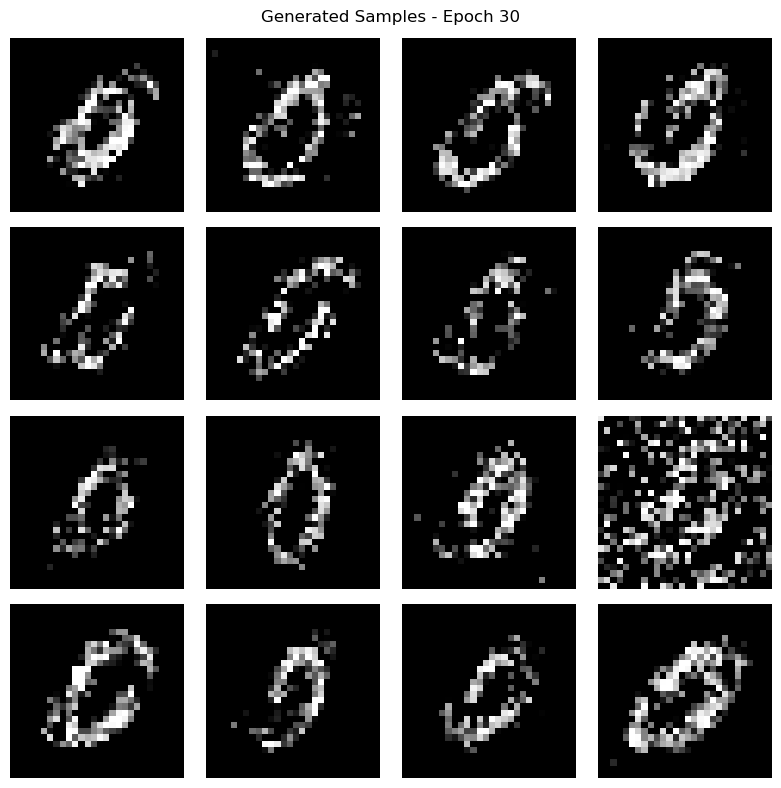

100%|██████████| 5/5 [00:00<00:00, 22.03it/s]


Epoch 31 completed. Train: Loss: -0.12104, CD Loss: -0.14063, Reg Loss: 0.01959, E_real: -0.2230, E_fake: -0.0824,
Val: Loss: -0.02863, CD Loss: -0.06234, Reg Loss: 0.03370, E_real: -0.4295, E_fake: -0.3671, E_rand: 3.6776, (Best: -0.18550 at epoch 23)


100%|██████████| 5/5 [00:00<00:00, 23.27it/s]


Epoch 32 completed. Train: Loss: -0.10933, CD Loss: -0.12774, Reg Loss: 0.01840, E_real: -0.2293, E_fake: -0.1015,
Val: Loss: -0.11266, CD Loss: -0.11686, Reg Loss: 0.00420, E_real: -0.0649, E_fake: 0.0520, E_rand: 3.6596, (Best: -0.18550 at epoch 23)


100%|██████████| 5/5 [00:00<00:00, 20.35it/s]

Epoch 33 completed. Train: Loss: -0.11326, CD Loss: -0.12999, Reg Loss: 0.01673, E_real: -0.1985, E_fake: -0.0685,
Val: Loss: -0.07118, CD Loss: -0.09208, Reg Loss: 0.02090, E_real: -0.3546, E_fake: -0.2626, E_rand: 3.7848, (Best: -0.18550 at epoch 23)

Early stopping triggered after 10 epochs without improvement.
Best validation loss: -0.1855 at epoch 23


In [10]:
train_losses, val_losses = trainer.train(train_dataloader, val_dataloader, num_epochs=40)

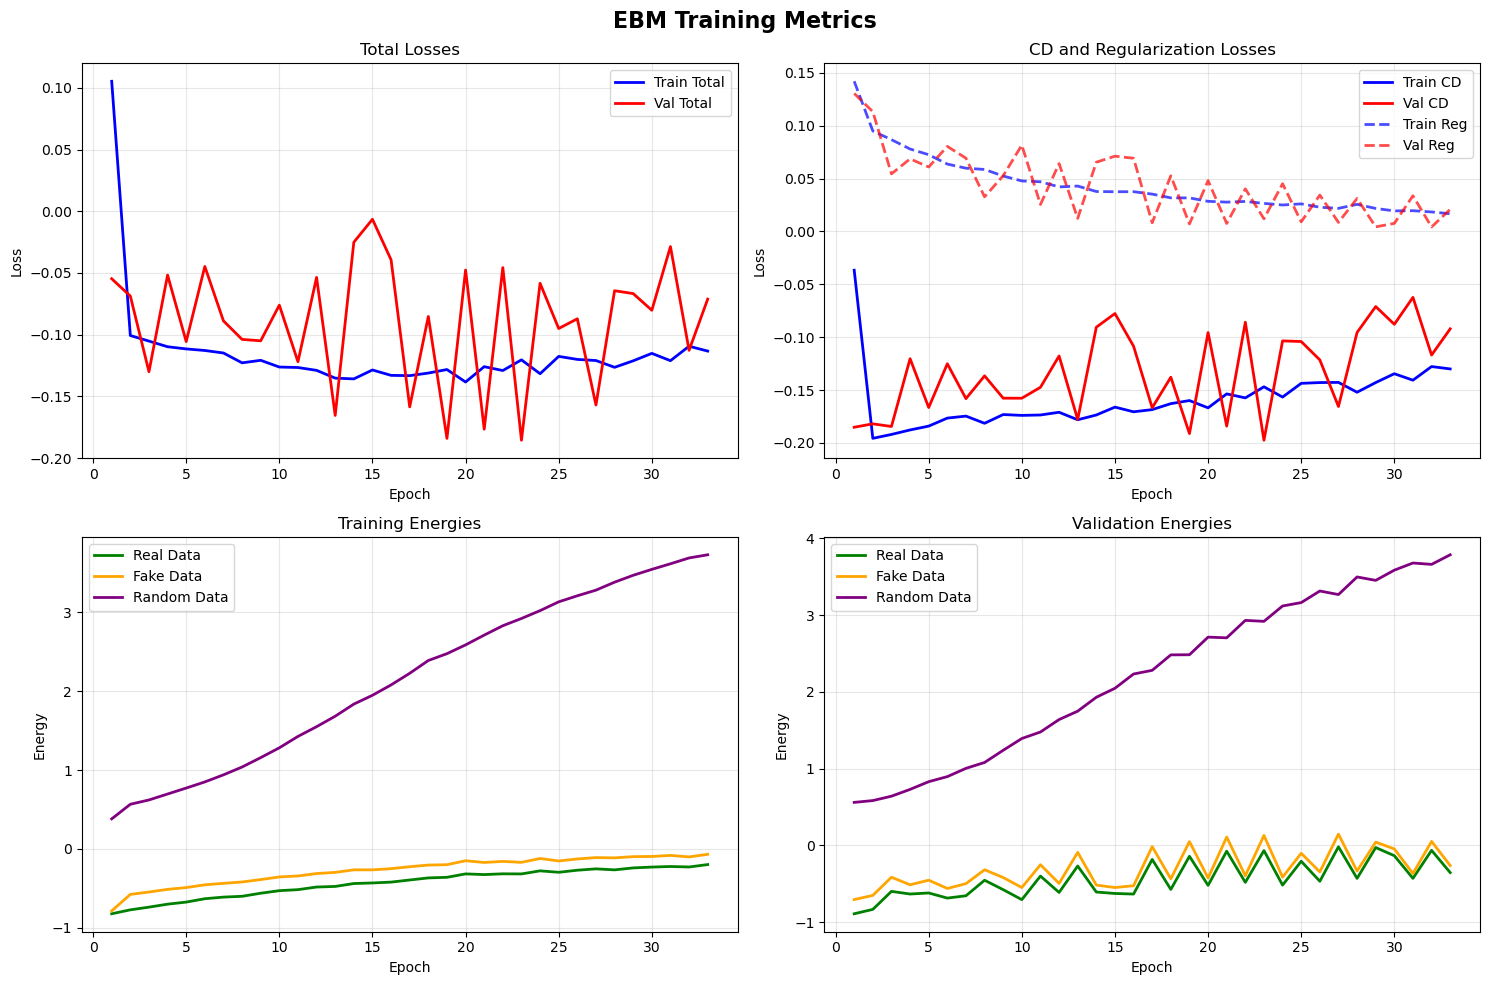

In [20]:
metrics = trainer.metrics

"""Plot comprehensive EBM training metrics."""
epochs = range(1, len(metrics.train_losses) + 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EBM Training Metrics', fontsize=16, fontweight='bold')

# Plot 1: Total Losses
axes[0, 0].plot(epochs, metrics.train_losses, 'b-', label='Train Total', linewidth=2)
axes[0, 0].plot(epochs, metrics.val_losses, 'r-', label='Val Total', linewidth=2)
axes[0, 0].set_title('Total Losses')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: CD and Regularization Losses
axes[0, 1].plot(epochs, metrics.train_losses_cd, 'b-', label='Train CD', linewidth=2)
axes[0, 1].plot(epochs, metrics.val_losses_cd, 'r-', label='Val CD', linewidth=2)
axes[0, 1].plot(epochs, metrics.train_losses_reg, 'b--', label='Train Reg', linewidth=2, alpha=0.7)
axes[0, 1].plot(epochs, metrics.val_losses_reg, 'r--', label='Val Reg', linewidth=2, alpha=0.7)
axes[0, 1].set_title('CD and Regularization Losses')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training Energies
axes[1, 0].plot(epochs, metrics.train_energies_real, 'g-', label='Real Data', linewidth=2)
axes[1, 0].plot(epochs, metrics.train_energies_fake, 'orange', label='Fake Data', linewidth=2)
axes[1, 0].plot(epochs, metrics.train_energies_rand, 'purple', label='Random Data', linewidth=2)
axes[1, 0].set_title('Training Energies')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Energy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Validation Energies
axes[1, 1].plot(epochs, metrics.val_energies_real, 'g-', label='Real Data', linewidth=2)
axes[1, 1].plot(epochs, metrics.val_energies_fake, 'orange', label='Fake Data', linewidth=2)
axes[1, 1].plot(epochs, metrics.val_energies_rand, 'purple', label='Random Data', linewidth=2)
axes[1, 1].set_title('Validation Energies')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Energy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()